<a href="https://colab.research.google.com/github/dmeadows95/CS4783_FinalProject/blob/main/CS4783_FinalProject_DamonMeadows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os
from sklearn.naive_bayes import GaussianNB
import math
import numpy as np
from numpy.linalg import norm
from sklearn.neighbors import KNeighborsClassifier

# create headers for data
features = ['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'Concave Points', 'Symmetry', 'Fractal Dimension']
column_names = ['ID', 'Diagnosis']
for attr in ['Mean', 'SE', 'Largest']:
  for feature in features:
    column_names.append(feature + " " + attr)

# read in data with headers
data =  pd.read_csv('drive/MyDrive/MyDrive/wdbc.data', names=column_names)

# create training set
train_data = data.sample(frac=0.75)

# create test set
test_data = data.drop(train_data.index)

# remove id column from data (each row is unique)
# split data into features and labels
# copy data for each model
log_x_train, log_y_train = train_data.iloc[:,2:], train_data.iloc[:, 1]
log_x_test, log_y_test = test_data.iloc[:, 2:], test_data.iloc[:, 1]
knn_x_train, knn_y_train = train_data.iloc[:,2:], train_data.iloc[:, 1]
knn_x_test, knn_y_test = test_data.iloc[:, 2:], test_data.iloc[:, 1]
bayes_x_train, bayes_y_train = train_data.iloc[:,2:], train_data.iloc[:, 1]
bayes_x_test, bayes_y_test = test_data.iloc[:, 2:], test_data.iloc[:, 1]
feedForward_x_train, feedForward_y_train = train_data.iloc[:,2:], train_data.iloc[:, 1]
feedForward_x_test, feedForward_y_test = test_data.iloc[:, 2:], test_data.iloc[:, 1]

# preprocess diagnosis (M or B) into 0s and 1s
log_y_train, log_y_test = log_y_train.map({'B': 0, 'M': 1}), log_y_test.map({'B': 0, 'M': 1})
knn_y_train, knn_y_test = knn_y_train.map({'B': 0, 'M': 1}), knn_y_test.map({'B': 0, 'M': 1})
bayes_y_train, bayes_y_test = bayes_y_train.map({'B': 0, 'M': 1}), bayes_y_test.map({'B': 0, 'M': 1})
feedForward_y_train, feedForward_y_test = feedForward_y_train.map({'B': 0, 'M': 1}), feedForward_y_test.map({'B': 0, 'M': 1})

# convert data set to tensor
log_x_train, log_y_train = tf.convert_to_tensor(log_x_train, dtype=tf.float32), tf.convert_to_tensor(log_y_train, dtype=tf.float32)
log_x_test, log_y_test = tf.convert_to_tensor(log_x_test, dtype=tf.float32), tf.convert_to_tensor(log_y_test, dtype=tf.float32)
#knn_x_train, knn_y_train = tf.convert_to_tensor(knn_x_train, dtype=tf.float32), tf.convert_to_tensor(knn_y_train, dtype=tf.float32)
#knn_x_test, knn_y_test = tf.convert_to_tensor(knn_x_test, dtype=tf.float32), tf.convert_to_tensor(knn_y_test, dtype=tf.float32)
bayes_x_train, bayes_y_train = tf.convert_to_tensor(bayes_x_train, dtype=tf.float32), tf.convert_to_tensor(bayes_y_train, dtype=tf.float32)
bayes_x_test, bayes_y_test = tf.convert_to_tensor(bayes_x_test, dtype=tf.float32), tf.convert_to_tensor(bayes_y_test, dtype=tf.float32)
#feedForward_x_train, feedForward_y_train = tf.convert_to_tensor(feedForward_x_train, dtype=tf.float32), tf.convert_to_tensor(feedForward_y_train, dtype=tf.float32)
#feedForward_x_test, feedForward_y_test = tf.convert_to_tensor(feedForward_x_test, dtype=tf.float32), tf.convert_to_tensor(feedForward_y_test, dtype=tf.float32)

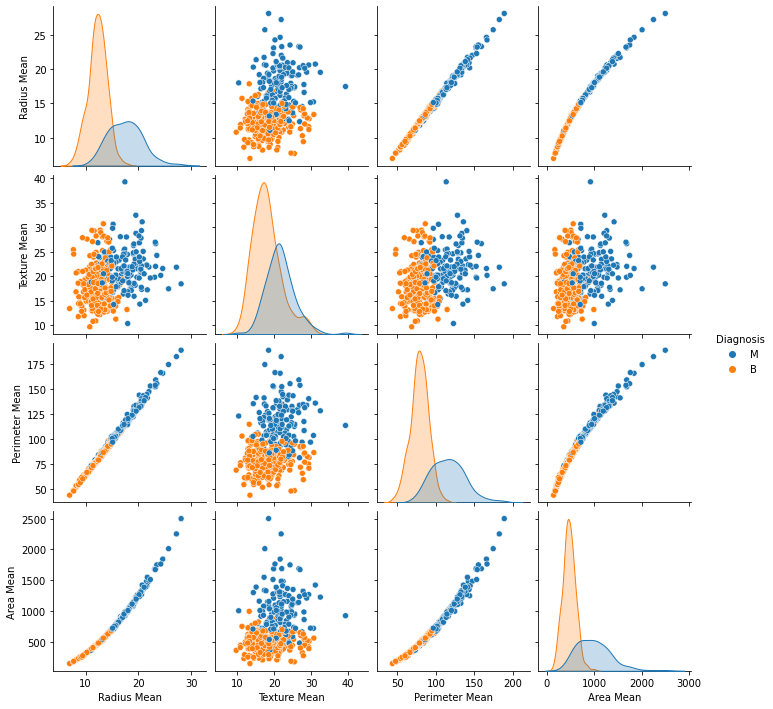

In [25]:
# use pairplot to review joint distribution of a few pairs of features
sns.pairplot(train_data.iloc[:, 1:6], hue = 'Diagnosis', diag_kind='kde')

In [26]:
# check overall statistics
train_data.describe().transpose()[:10]

,count,mean,std,min,25%,50%,75%,max
ID,427.0,3.106923e+07,1.296072e+08,8670.00000,869472.500000,908469.00000,8.885476e+06,9.113205e+08
Radius Mean,427.0,1.420588e+01,3.522741e+00,6.98100,11.800000,13.40000,1.609000e+01,2.811000e+01
Texture Mean,427.0,1.932333e+01,4.276133e+00,9.71000,16.275000,18.77000,2.181500e+01,3.928000e+01
Perimeter Mean,427.0,9.248208e+01,2.425711e+01,43.79000,75.625000,86.87000,1.049000e+02,1.885000e+02
Area Mean,427.0,6.617424e+02,3.519641e+02,143.50000,430.000000,552.40000,8.025500e+02,2.499000e+03
Smoothness Mean,427.0,9.575211e-02,1.412900e-02,0.05263,0.085190,0.09491,1.044000e-01,1.634000e-01
Compactness Mean,427.0,1.040807e-01,5.164138e-02,0.01938,0.066545,0.09453,1.286500e-01,3.454000e-01
Concavity Mean,427.0,8.834395e-02,7.708515e-02,0.00000,0.030790,0.06181,1.230500e-01,4.268000e-01
Concave Points Mean,427.0,4.889037e-02,3.847990e-02,0.00000,0.020990,0.03264,7.202000e-02,2.012000e-01
Symmetry Mean,427.0,1.798578e-01,2.812282e-02,0.10600,0.160150,0.17690,1.944500e-01,3.040000e-01


In [27]:
# normalize data
class Normalize(tf.Module):
  # initialize the mean and standard deviation for normalization
  def __init__(self, x):
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  # normalize input
  def norm(self, x):
    return(x - self.mean)/self.std

  # undo normalization
  def undo_norm(self, x):
    return (x * self.std) + self.mean

log_norm_x = Normalize(log_x_train)
#knn_norm_x = Normalize(knn_x_train)
bayes_norm_x = Normalize(bayes_x_train)
#feedForward_norm_x = Normalize(feedForward_x_train)

log_x_train_norm, log_x_test_norm = log_norm_x.norm(log_x_train), log_norm_x.norm(log_x_test)
#knn_x_train_norm, knn_x_test_norm = knn_norm_x.norm(knn_x_train), knn_norm_x.norm(knn_x_test)
bayes_x_train_norm, bayes_x_test_norm = bayes_norm_x.norm(bayes_x_train), bayes_norm_x.norm(bayes_x_test)
#feedForward_x_train_norm, feedForward_x_test_norm = feedForward_norm_x.norm(feedForward_x_train), feedForward_norm_x.norm(feedForward_x_test)

In [28]:
# Logisitc Regression Model
class LogisticRegression(tf.Module):
  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # initialize model parameters on first call
    if not self.built:
      # randomly generate the weights and the bias term
      random_weights = tf.random.uniform(shape=[x.shape[-1], 1])
      random_biases = tf.random.uniform(shape=[])
      self.w = tf.Variable(random_weights)
      self.b = tf.Variable(random_biases)
      self.built = True
    # compute model output
    output = tf.add(tf.matmul(x, self.w), self.b)
    output = tf.squeeze(output, axis=1)
    if train:
      return output
    return tf.sigmoid(output)

log_reg= LogisticRegression()

In [29]:
# return tensor with 1 if log_y_pred > thresh; return 0 otherwise
def predict_class(log_y_pred, thresh=0.5):
  return tf.cast(log_y_pred > thresh, tf.float32)

# accuracy function to return proportion of matches between y and log_y_pred
def accuracy(log_y_pred, y):
  log_y_pred = tf.math.sigmoid(log_y_pred)
  log_y_pred_class = predict_class(log_y_pred)
  check_equal = tf.cast(log_y_pred_class == y, tf.float32)
  accuracy_value = tf.reduce_mean(check_equal)
  return accuracy_value

In [30]:
# minibatch data
batch_size = 64
train_data = tf.data.Dataset.from_tensor_slices((log_x_train_norm, log_y_train))
train_data = train_data.shuffle(buffer_size=log_x_train.shape[0]).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((log_x_test_norm, log_y_test))
test_data = test_data.shuffle(buffer_size=log_x_test.shape[0]).batch(batch_size)

In [31]:
# log loss function
def log_loss(y_pred, y):
  loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(loss)

In [32]:
# training parameters
epochs = 300
learning_rate = 0.01
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# set up training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accuracies_train = [], []
  batch_losses_test, batch_accuracies_test = [], []

  # iterate over training data
  for x_batch, y_batch in train_data:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_accuracy = accuracy(y_pred_batch, y_batch)
    # update parameters with respect to gradients
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g, v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # track batch level training performance
    batch_losses_train.append(batch_loss)
    batch_accuracies_train.append(batch_accuracy)

  # iterate over testing data
  for x_batch, y_batch in test_data:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_accuracy = accuracy(y_pred_batch, y_batch)
    # track batch level testing performance
    batch_losses_test.append(batch_loss)
    batch_accuracies_test.append(batch_accuracy)

  # track epoch performance
  train_loss, train_accuracy = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accuracies_train)
  test_loss, test_accuracy = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accuracies_test)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss: .3f}")

Epoch: 0, Training log loss:  0.699
Epoch: 20, Training log loss:  0.416
Epoch: 40, Training log loss:  0.246
Epoch: 60, Training log loss:  0.171
Epoch: 80, Training log loss:  0.139
Epoch: 100, Training log loss:  0.117
Epoch: 120, Training log loss:  0.106
Epoch: 140, Training log loss:  0.106
Epoch: 160, Training log loss:  0.100
Epoch: 180, Training log loss:  0.093
Epoch: 200, Training log loss:  0.091
Epoch: 220, Training log loss:  0.089
Epoch: 240, Training log loss:  0.086
Epoch: 260, Training log loss:  0.085
Epoch: 280, Training log loss:  0.083


Text(0.5, 1.0, 'Log Loss vs Training Iterations')

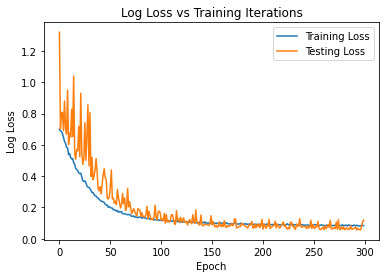

In [33]:
# performance evaluation: log loss
plt.plot(range(epochs), train_losses, label = "Training Loss")
plt.plot(range(epochs), test_losses, label = "Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.legend()
plt.title("Log Loss vs Training Iterations")

Text(0.5, 1.0, 'Accuracy vs Training Iterations')

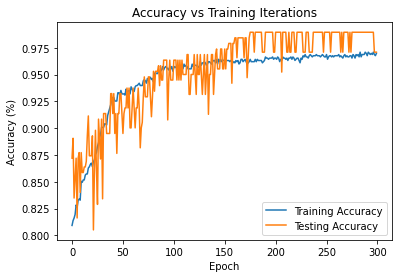

In [34]:
# performance evaluation: accuracy
plt.plot(range(epochs), train_accuracies, label = "Training Accuracy")
plt.plot(range(epochs), test_accuracies, label = "Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs Training Iterations")

In [35]:
# diplay final accuracy and log loss
print(f"Final Training Log Loss: {train_losses[-1]: .3f}")
print(f"Final Testing Log Loss: {test_losses[-1]: .3f}")
print(f"Final Training Accuracy: {train_accuracies[-1]: .3f}")
print(f"Final Testing Accuracy: {test_accuracies[-1]: .3f}")

Final Training Log Loss:  0.083
Final Testing Log Loss:  0.118
Final Training Accuracy:  0.970
Final Testing Accuracy:  0.971


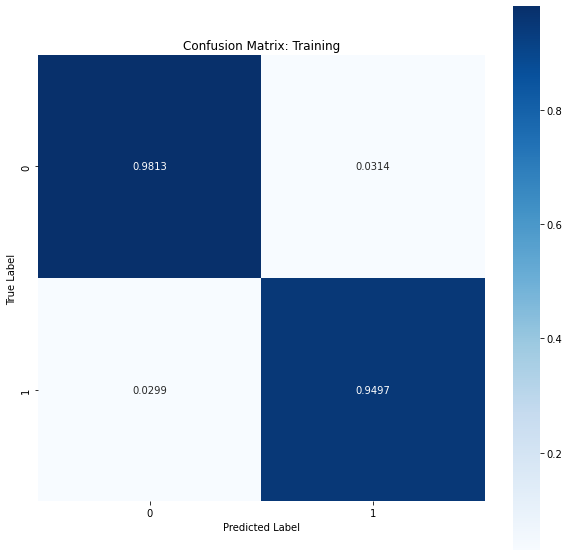

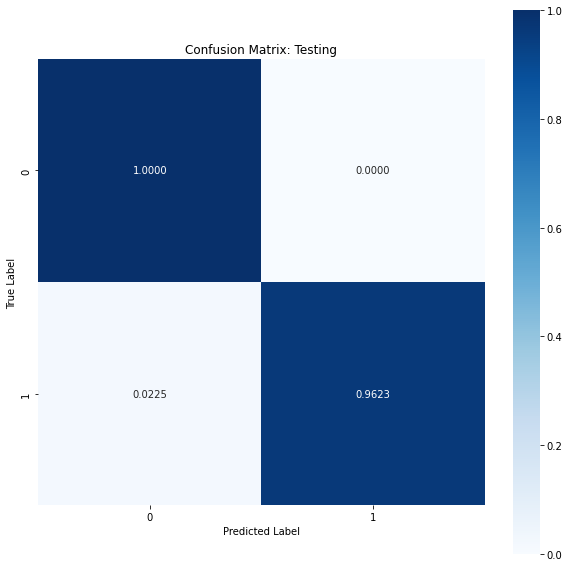

In [36]:
# create confusion matrix to identify false positive and false negative rates
def show_confusion_matrix(y, y_classes, typ):
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels, cmap='Blues', annot=True, fmt='.4f', square=True
  )
  plt.title(f"Confusion Matrix: {typ}")
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")

y_pred_train, y_pred_test = log_reg(log_x_train_norm, train=False), log_reg(log_x_test_norm, train=False)
log_train_classes, log_test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

show_confusion_matrix(log_y_train, log_train_classes, 'Training')
show_confusion_matrix(log_y_test, log_test_classes, 'Testing')

In [57]:
# Gaussian Naive Bayes
gnb = GaussianNB()

y_pred = gnb.fit(bayes_x_train, bayes_y_train).predict(bayes_x_test)

sum =  0
total = 0
while (total < 142):
  if (y_pred[total] == bayes_y_test[total]):
    sum += 1
  total += 1

accuracy = sum / total

print("Gaussian Naive Bayes accuracy: ", accuracy)


Gaussian Naive Bayes accuracy:  0.9154929577464789


Accuracy at k = 40:
0.9084507042253521


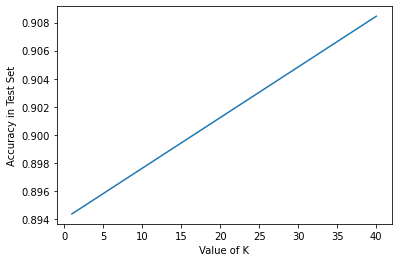

In [54]:
# KNN

k_range = (1,40)
scores = {}
scores_list = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(knn_x_train,knn_y_train)
  y_pred = knn.predict(knn_x_test)
  scores[k] = sk_metrics.accuracy_score(knn_y_test,y_pred)
  scores_list.append(sk_metrics.accuracy_score(knn_y_test,y_pred))

plt.plot(k_range, scores_list)
plt.xlabel('Value of K')
plt.ylabel('Accuracy in Test Set')
print('Accuracy at k = 40:')
print(scores[40])

Accuracy at k = 50:
0.8943661971830986


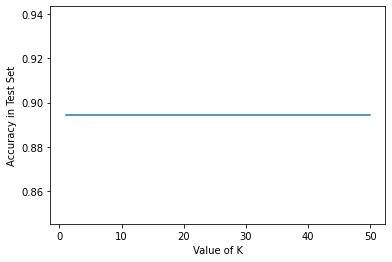

In [53]:
k_range = (1,50)
scores = {}
scores_list = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(knn_x_train,knn_y_train)
  y_pred = knn.predict(knn_x_test)
  scores[k] = sk_metrics.accuracy_score(knn_y_test,y_pred)
  scores_list.append(sk_metrics.accuracy_score(knn_y_test,y_pred))

plt.plot(k_range, scores_list)
plt.xlabel('Value of K')
plt.ylabel('Accuracy in Test Set')

print('Accuracy at k = 50:')
print(scores[50])

In [55]:
# Feed Forward Neural Network
FeedForward = Sequential()
FeedForward.add(Dense(8, input_shape = (30,), activation='relu'))
FeedForward.add(Dense(16, activation='relu'))
FeedForward.add(Dense(32, activation='relu'))
FeedForward.add(Dense(64, activation='relu'))
FeedForward.add(Dense(128, activation='relu'))
FeedForward.add(Dense(64, activation='relu'))
FeedForward.add(Dense(32, activation='relu'))
FeedForward.add(Dense(16, activation='relu'))
FeedForward.add(Dense(8, activation='relu'))
FeedForward.add(Dense(1, activation='softmax'))

FeedForward.summary()

optimizer = keras.optimizers.SGD(learning_rate=.1)

# compile model using accuracy to measure model performance
FeedForward.compile(
      optimizer=optimizer, 
      loss='categorical_crossentropy',
      metrics=['accuracy'])

FeedForward.fit(
    feedForward_x_train, 
    feedForward_y_train,
    batch_size = 1, 
    validation_data=(feedForward_x_test, feedForward_y_test), epochs=7)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 248       
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2